In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import zscore
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [2]:
# set color catgory
cat = 'color'

In [3]:
# load C data and X data
cdf = pd.read_csv('C_Mod.csv')
xdf = pd.read_csv('X_Mod.csv')

In [4]:
# Drop rows with NaN values
xdrops = xdf[xdf.isna().any(axis=1)].index.tolist()
cdrops = cdf[cdf.isna().any(axis=1)].index.tolist()
nans = xdrops + cdrops
print("NaN rows dropped:", nans)

NaN rows dropped: [26, 36, 23]


In [5]:
# Re-assign cdf and xdf
cdf = cdf.drop(nans)
xdf = xdf.drop(nans)

In [6]:
# Cell 4: Prepare data for PLS regression
# Get colors and IDs
levs = xdf['color'].tolist()
myid = xdf['Sample'].tolist()  # for labeling by index if needed



In [7]:
X = xdf
y = cdf

## Explantory Data Analysis to select
- outliers
- Correlation analysis on features: drop highly correlated variables
- Scatterplots
- PCA

In [8]:
X.columns

Index(['Sample', 'color', 'NMR1', 'NMR2', 'NMR3', 'NMR4', 'NMR5', 'NMR6',
       'NMR7', 'NMR8',
       ...
       'NMR264', 'NMR265', 'NMR266', 'NMR267', 'NMR268', 'NMR269', 'NMR270',
       'NMR271', 'NMR272', 'NMR273'],
      dtype='object', length=275)

In [9]:
%pip install outlier-utils
from OUTLIERS import smirnov_grubbs as grubbs

Note: you may need to restart the kernel to use updated packages.


In [10]:
nmr_list = []
for i in range(1, 273):
  nmr_list.append(f'NMR{i}')
for nmr in nmr_list:
  data = X[nmr].tolist()
  result = grubbs.max_test_indices(data, alpha=0.05)
  if result:
    print(f'The index of outlier in variable {nmr} is {result}')

The index of outlier in variable NMR1 is [31]
The index of outlier in variable NMR4 is [32]
The index of outlier in variable NMR7 is [22]
The index of outlier in variable NMR9 is [15]
The index of outlier in variable NMR10 is [29]
The index of outlier in variable NMR33 is [22]
The index of outlier in variable NMR35 is [22, 32, 21, 29]
The index of outlier in variable NMR37 is [22]
The index of outlier in variable NMR38 is [22]
The index of outlier in variable NMR39 is [22]
The index of outlier in variable NMR40 is [16, 34]
The index of outlier in variable NMR41 is [22]
The index of outlier in variable NMR42 is [21, 9]
The index of outlier in variable NMR44 is [32, 21]
The index of outlier in variable NMR47 is [32, 21, 33]
The index of outlier in variable NMR50 is [22]
The index of outlier in variable NMR52 is [32]
The index of outlier in variable NMR55 is [32]
The index of outlier in variable NMR56 is [32]
The index of outlier in variable NMR57 is [22, 32, 21, 25, 29]
The index of outl

In [11]:
y.columns, X.columns

(Index(['Sample', 'color', 'Malic', 'Ethanol', 'Total', 'Volatile',
        'Lactic_Acid', 'Tartaric', 'Glucose', 'Density', 'Folin', 'Glycerol',
        'Gluconic', 'Sorbic', 'CO2', 'Citric', 'Methanol', 'Ethylacetate',
        'pH'],
       dtype='object'),
 Index(['Sample', 'color', 'NMR1', 'NMR2', 'NMR3', 'NMR4', 'NMR5', 'NMR6',
        'NMR7', 'NMR8',
        ...
        'NMR264', 'NMR265', 'NMR266', 'NMR267', 'NMR268', 'NMR269', 'NMR270',
        'NMR271', 'NMR272', 'NMR273'],
       dtype='object', length=275))

In [12]:
target_list = ['Malic', 'Ethanol', 'Total', 'Volatile','Lactic_Acid', 'Tartaric', 'Glucose', 'Density', 'Folin', 'Glycerol','Gluconic', 'Sorbic', 'CO2', 'Citric', 'Methanol', 'Ethylacetate','pH']
for target in target_list:
  data = y[target].tolist()
  result = grubbs.max_test_indices(data, alpha=0.05)
  if result:
    print(f'The index of outlier in variable {target} is {result}')

The index of outlier in variable Malic is [5]
The index of outlier in variable Total is [18]
The index of outlier in variable Lactic_Acid is [13]
The index of outlier in variable CO2 is [11, 16, 18]
The index of outlier in variable Citric is [21]
The index of outlier in variable Ethylacetate is [18]


In [13]:
import numpy as np
import pandas as pd

# Function to identify and replace outliers
def replace_outliers_with_median(df, color_column_level, nmr_columns):
    for column in nmr_columns:
        # Group by the specified index level using the level number
        grouped = df.groupby(level=color_column_level)

        # Define a function to replace outliers with median
        def replace_outliers(group):
            # Calculate Q1 (25th percentile) and Q3 (75th percentile)
            Q1 = group[column].quantile(0.25)
            Q3 = group[column].quantile(0.75)
            IQR = Q3 - Q1

            # Define the outlier range
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Calculate the median for the group
            median = group[column].median()

            # Replace outliers with the median
            group[column] = np.where((group[column] < lower_bound) | (group[column] > upper_bound), median, group[column])
            return group

        # Apply the outlier replacement function to each group and reset index to maintain color
        df = grouped.apply(replace_outliers).reset_index(level=color_column_level, drop=True)  # Changed drop=False to drop=True

    return df

# List of NMR columns
nmr_columns = [f"NMR{i}" for i in range(1, 273)]  # Modify this list to include all NMR columns
target_columns = ['Malic', 'Ethanol', 'Total', 'Volatile', 'Lactic_Acid', 'Tartaric', 'Glucose', 'Density', 'Folin', 'Glycerol', 'Gluconic', 'Sorbic', 'CO2', 'Citric', 'Methanol', 'Ethylacetate', 'pH']

# Set 'color' as the index
X = X.set_index('color')

# Replace outliers, using level=0 since 'color' is now the first level of the index
X_outlier = replace_outliers_with_median(X, color_column_level=0, nmr_columns=nmr_columns)
y_outlier = replace_outliers_with_median(y, color_column_level=0, nmr_columns=target_columns)


In [14]:
X_outlier.shape

(37, 274)

In [15]:
# Assuming X is your dataframe of features
corr_matrix = X_outlier.corr()

# Plotting the correlation matrix
# plt.figure(figsize=(10,8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
# plt.title('Correlation Matrix')
# plt.show()

# Dropping highly correlated variables (example threshold 0.9)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.9)]
X_dropped = X_outlier.drop(X_outlier[to_drop], axis=1)
print(X_outlier.shape)
print(X_dropped.shape)
X_dropped.columns

(37, 274)
(37, 186)


Index(['Sample', 'NMR1', 'NMR2', 'NMR3', 'NMR4', 'NMR5', 'NMR6', 'NMR7',
       'NMR8', 'NMR10',
       ...
       'NMR243', 'NMR244', 'NMR250', 'NMR253', 'NMR254', 'NMR255', 'NMR256',
       'NMR257', 'NMR268', 'NMR271'],
      dtype='object', length=186)

In [16]:
y

,Sample,color,Malic,Ethanol,Total,Volatile,Lactic_Acid,Tartaric,Glucose,Density,Folin,Glycerol,Gluconic,Sorbic,CO2,Citric,Methanol,Ethylacetate,pH
0,1,white,1.659100,13.362000,3.2351,0.201970,0.22088,1.9346,6.802000,0.99610,3.454600,7.188799,0.125110,-1.228100,615.330017,0.663300,0.059090,39.568001,3.41
1,2,red,0.214060,12.887000,3.4987,0.467540,0.88723,2.5563,0.063616,0.99409,59.650005,8.257400,0.510290,17.209999,316.290008,0.089694,0.184830,252.929993,3.42
2,3,red,0.245190,13.044000,3.6213,0.486140,1.35750,2.4463,1.097400,0.99705,68.738998,9.604400,1.416500,16.408001,282.640015,0.266330,0.180190,-58.270000,3.64
3,4,white,2.256100,11.848000,3.7846,0.227750,0.30157,1.5710,0.403360,0.99291,10.412000,7.121000,0.345230,37.365002,582.960022,0.323460,0.053365,470.079987,3.24
4,5,red,0.294230,13.613000,2.9792,0.538590,1.48750,1.9834,1.770200,0.99666,75.089996,8.950600,-1.718500,-115.079994,230.509995,0.058963,0.112100,-222.850021,3.64
5,6,white,3.117500,12.018001,3.9126,0.380620,0.26350,1.1353,0.396450,0.99214,11.732999,5.728500,-0.037167,84.053001,766.119934,0.368370,0.024013,569.080017,3.36
6,7,red,0.070986,13.050000,3.4736,0.555920,1.66410,2.3082,-0.111440,0.99534,60.371998,8.930700,0.500000,-8.159300,391.709992,0.113820,0.180300,-165.889999,3.69
7,8,rose,1.262700,12.002000,2.9178,0.186750,0.21736,1.5407,0.124300,0.99140,17.547001,5.750200,0.377330,33.666000,623.260010,0.238160,0.048496,12.468999,3.17
8,9,red,0.429280,13.990001,3.6727,0.310760,1.11050,2.4753,0.380610,0.99468,55.776997,9.032600,-1.144800,23.883001,242.990005,0.241310,0.202810,43.715000,3.39
9,10,red,0.280540,12.111000,3.3800,0.410860,1.50460,2.2342,-0.044855,0.99438,50.771000,7.971600,-0.192260,-43.514999,448.760010,0.143290,0.119020,340.950012,3.48


In [17]:
X_numeric = X_dropped.drop(columns='Sample')
print(X_numeric)
y_numeric = y_outlier.drop(columns=['Sample', 'color'])
y_numeric


               NMR1          NMR2          NMR3          NMR4          NMR5  \
color                                                                         
red    -4012.053611  -5272.839157  -6589.119338  -4820.657009  -5893.250973   
red   -11570.148850 -13729.982010 -16034.198700    499.977912   -166.374156   
red    -6395.170087  -1441.334574  -3548.368165  -3488.754482  -4183.275564   
red     1171.438453    197.637033   -951.024100    499.977912    -39.282719   
red    -2432.371071  -2397.918522   3074.372725   4121.565214    560.082361   
red       -4.212341   6764.862609   4521.490990   2940.541292   1048.273731   
red    -3693.198256  -1584.433166  -2563.579432  -2420.585468  -2002.993874   
red   -11831.736150 -13201.728050 -12491.341560 -11228.276060 -12778.330340   
red   -24817.132980 -13049.347090  -7754.833624 -12846.053830  -6614.520814   
red     1487.646814  -2805.841616  -6775.410418  -6623.402370  -5473.416410   
red    -4234.043327  -3215.982461  -9222.734362  -62

,Malic,Ethanol,Total,Volatile,Lactic_Acid,Tartaric,Glucose,Density,Folin,Glycerol,Gluconic,Sorbic,CO2,Citric,Methanol,Ethylacetate,pH
0,1.659100,13.362000,3.2351,0.201970,0.22088,1.9346,6.802000,0.99610,3.454600,7.188799,0.125110,-1.228100,615.330017,0.663300,0.059090,39.568001,3.41
1,0.214060,12.887000,3.4987,0.467540,0.88723,2.5563,0.063616,0.99409,59.650005,8.257400,0.510290,17.209999,316.290008,0.089694,0.184830,252.929993,3.42
2,0.245190,13.044000,3.6213,0.486140,1.35750,2.4463,1.097400,0.99705,68.738998,9.604400,1.416500,16.408001,282.640015,0.266330,0.180190,-58.270000,3.64
3,2.256100,11.848000,3.7846,0.227750,0.30157,1.5710,0.403360,0.99291,10.412000,7.121000,0.345230,37.365002,582.960022,0.323460,0.053365,470.079987,3.24
4,0.294230,13.613000,2.9792,0.538590,1.48750,1.9834,1.770200,0.99666,75.089996,8.950600,-1.718500,-115.079994,230.509995,0.058963,0.112100,-222.850021,3.64
5,3.117500,12.018001,3.9126,0.380620,0.26350,1.1353,0.396450,0.99214,11.732999,5.728500,-0.037167,84.053001,766.119934,0.368370,0.024013,569.080017,3.36
6,0.070986,13.050000,3.4736,0.555920,1.66410,2.3082,-0.111440,0.99534,60.371998,8.930700,0.500000,-8.159300,391.709992,0.113820,0.180300,-165.889999,3.69
7,1.262700,12.002000,2.9178,0.186750,0.21736,1.5407,0.124300,0.99140,17.547001,5.750200,0.377330,33.666000,623.260010,0.238160,0.048496,12.468999,3.17
8,0.429280,13.990001,3.6727,0.310760,1.11050,2.4753,0.380610,0.99468,55.776997,9.032600,-1.144800,23.883001,242.990005,0.241310,0.202810,43.715000,3.39
9,0.280540,12.111000,3.3800,0.410860,1.50460,2.2342,-0.044855,0.99438,50.771000,7.971600,-0.192260,-43.514999,448.760010,0.143290,0.119020,340.950012,3.48


In [18]:
print(X_numeric)
print(y_numeric)

               NMR1          NMR2          NMR3          NMR4          NMR5  \
color                                                                         
red    -4012.053611  -5272.839157  -6589.119338  -4820.657009  -5893.250973   
red   -11570.148850 -13729.982010 -16034.198700    499.977912   -166.374156   
red    -6395.170087  -1441.334574  -3548.368165  -3488.754482  -4183.275564   
red     1171.438453    197.637033   -951.024100    499.977912    -39.282719   
red    -2432.371071  -2397.918522   3074.372725   4121.565214    560.082361   
red       -4.212341   6764.862609   4521.490990   2940.541292   1048.273731   
red    -3693.198256  -1584.433166  -2563.579432  -2420.585468  -2002.993874   
red   -11831.736150 -13201.728050 -12491.341560 -11228.276060 -12778.330340   
red   -24817.132980 -13049.347090  -7754.833624 -12846.053830  -6614.520814   
red     1487.646814  -2805.841616  -6775.410418  -6623.402370  -5473.416410   
red    -4234.043327  -3215.982461  -9222.734362  -62

In [19]:
X_numeric_reset = X_numeric.reset_index(drop=True)
y_numeric_reset = y_numeric.reset_index(drop=True)

In [20]:
# Get column names
cnames = y_outlier.columns.tolist()
xnames = X_outlier.columns.tolist()

In [21]:
# # Assuming y is your target variable, plotting scatterplot of a specific feature against y
# import seaborn as sns

# # Scatterplot of feature 'feature1' vs response y
# sns.scatterplot(data=X, x='NMR1', y=y)
# plt.title('Scatterplot of Feature1 vs Target')
# plt.show()

# # Scatterplot matrix for multiple variables
# sns.pairplot(pd.concat([X, y], axis=1))
# plt.title('Pairplot of Features and Target')
# plt.show()


In [22]:
# from sklearn.decomposition import PCA
# import numpy as np

# # Standardizing the data before PCA
# from sklearn.preprocessing import StandardScaler
# X_scaled = StandardScaler().fit_transform(X_dropped)

# # Applying PCA
# pca = PCA(n_components=2)  # Example with 2 components
# X_pca = pca.fit_transform(X_scaled)

# # Plotting explained variance ratio
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Explained Variance')
# plt.title('PCA Explained Variance')
# plt.show()

# # Scatter plot of the first two principal components
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='plasma')
# plt.xlabel('First Principal Component')
# plt.ylabel('Second Principal Component')
# plt.title('PCA Result')
# plt.show()


In [23]:
# Simple PLS regression with 5 comps, let's see 
pls = PLSRegression(n_components=5, scale=True)
pls.fit(X_numeric_reset, y_numeric_reset)

PLSRegression(n_components=5)

In [24]:
# Extract loadings and scores
t_pls = pls.x_scores_
w_pls = pls.x_weights_
q_pls = pls.y_loadings_

In [25]:
# Cell 7: Plotting the PLS Biplot
colordic = {'red': 'red', 'rose': 'pink', 'white': 'yellow'}
plt.figure(figsize=(8,6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [26]:
# Scaling factors for biplot
wscale = 100
qscale = 100
sscale = 1

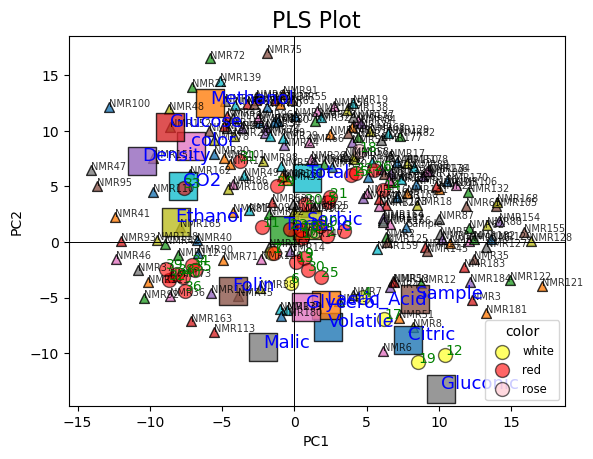

In [27]:
# Plot the w loadings (explanatory variables)
for i in range(len(w_pls)):
    plt.scatter(w_pls[i][0] * wscale, w_pls[i][1] * wscale, s=50, alpha=0.8, marker='^', edgecolor='black')
    plt.text(w_pls[i][0] * wscale, w_pls[i][1] * wscale, xnames[i], fontsize=7, color='black', alpha=0.8)

# Plot the q loadings (response variables)
for i in range(len(q_pls)):
    plt.scatter(q_pls[i][0] * qscale, q_pls[i][1] * qscale, s=400, alpha=0.8, marker='s', edgecolor='black')
    plt.text(q_pls[i][0] * qscale, q_pls[i][1] * qscale, cnames[i], fontsize=13, color='blue')

# Plot the samples (T)
used = []
scores = t_pls
for i in range(len(scores)):
    plt.text(scores[i][0] * sscale, scores[i][1] * sscale, myid[i], fontsize=10, color='green')
    if levs[i] in used:
        plt.scatter(scores[i][0] * sscale, scores[i][1] * sscale, s=100, alpha=0.6, color=colordic[levs[i]], edgecolor='black')
    else:
        plt.scatter(scores[i][0] * sscale, scores[i][1] * sscale, s=100, label=levs[i], color=colordic[levs[i]], alpha=0.6, edgecolor='black')
        used.append(levs[i])

# Add axis lines
plt.axhline(0, color='k', linestyle='-', linewidth=0.7)
plt.axvline(0, color='k', linestyle='-', linewidth=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add legend
plt.legend(title=cat, loc=4, fontsize='small')
plt.title('PLS Plot', fontsize=16)

plt.show()

In [28]:
pls.coef_


array([[-2.48348680e-07,  8.31692919e-07,  8.23064486e-08, ...,
         4.51044477e-07,  1.75658652e-06,  1.36739512e-06],
       [ 3.59977185e-07, -8.66761122e-07,  2.69477444e-07, ...,
        -3.30921638e-07, -1.77993376e-06, -1.20565162e-06],
       [ 5.22913449e-07,  4.95339931e-07,  8.86041456e-07, ...,
         2.34073579e-07, -1.04983118e-07,  3.73666771e-07],
       ...,
       [ 1.07073010e-07, -2.18614276e-08,  1.12918337e-07, ...,
        -1.78566578e-08, -2.15785192e-07, -1.11374873e-07],
       [-2.51738161e-04,  5.48715364e-04,  9.42613736e-05, ...,
         2.58890015e-04,  1.15905376e-03,  8.74806714e-04],
       [-4.98675846e-08, -3.71473804e-07, -2.89452438e-07, ...,
        -1.63260411e-07, -4.24572864e-07, -4.40703290e-07]])

## Effect plots

Consider about feature: Volatile, seems like NMR58, NMR229, NMR227, NMR230 are postively associated, and NMR101 NMR159, NMR107, NMR219 are negatively associated.

In [29]:
# # extract above NRM columns from X and Volatile from y to form a new df 
# X_vol = pd.DataFrame(X[['NMR58', 'NMR229', 'NMR227', 'NMR230', 'NMR101', 'NMR159', 'NMR107', 'NMR219']])
# y_vol = pd.DataFrame(y['pH'])

# df_Volalite = pd.concat([X_vol, y_vol], axis=1)
# df_Volalite

In [30]:
import statsmodels.formula.api as smf

In [31]:
print(f'X_numeric columns are: {X_numeric.columns}')
print(f'y_numeric columns are: {y_numeric.columns}')

X_numeric columns are: Index(['NMR1', 'NMR2', 'NMR3', 'NMR4', 'NMR5', 'NMR6', 'NMR7', 'NMR8', 'NMR10',
       'NMR14',
       ...
       'NMR243', 'NMR244', 'NMR250', 'NMR253', 'NMR254', 'NMR255', 'NMR256',
       'NMR257', 'NMR268', 'NMR271'],
      dtype='object', length=185)
y_numeric columns are: Index(['Malic', 'Ethanol', 'Total', 'Volatile', 'Lactic_Acid', 'Tartaric',
       'Glucose', 'Density', 'Folin', 'Glycerol', 'Gluconic', 'Sorbic', 'CO2',
       'Citric', 'Methanol', 'Ethylacetate', 'pH'],
      dtype='object')


In [32]:
# import pandas as pd
# import statsmodels.formula.api as smf
# import numpy as np

# def test_linear_regression_combinations(X, y):
#     # Ensure we only have numeric columns
#     X = X.select_dtypes(include=[np.number])
#     y = y.select_dtypes(include=[np.number])

#     results_table = pd.DataFrame(index=X.columns, columns=y.columns)

#     # Align X and y, checking for empty DataFrames
#     X, y = X.align(y, join='inner', axis=0)
    
#     print("Before checking emptiness - X:", X.shape, "y:", y.shape)  # Debug print

#     if X.empty or y.empty:
#         raise ValueError("Aligned DataFrames are empty.")

#     # Loop over each column in y and X
#     for y_col in y.columns:
#         for x_col in X.columns:
#             df_combined = pd.DataFrame({y_col: y[y_col], x_col: X[x_col]})

#             if df_combined.empty:
#                 continue  # Skip if combined DataFrame is empty

#             formula = f'{y_col} ~ {x_col}'

#             # Fit the linear regression model
#             lin_reg = smf.ols(formula, data=df_combined).fit()

#             # Extract the coefficient for the independent variable
#             coef = lin_reg.params[x_col]
#             results_table.at[x_col, y_col] = coef

#     return results_table

# # Example call to the function
# results_table = test_linear_regression_combinations(X_numeric, y_numeric)


In [33]:
# # Function to convert numbers in the DataFrame to 1, -1, or 0 based on sign
# def convert_sign_to_indicator(results_table):
#     # Define a lambda function to check the sign of each element
#     sign_converter = lambda x: 1 if x > 0 else (-1 if x < 0 else 0)
    
#     # Apply this function to the entire DataFrame using applymap
#     converted_table = results_table.map(sign_converter)
    
#     return converted_table
# converted_table = convert_sign_to_indicator(results_table)

# # save as a excel file

# converted_table.to_excel('effect_table.xlsx', index=True)



In [34]:
# formula = 'pH ~ NMR58 + NMR229 + NMR227	+ NMR230	+ NMR101 + NMR159 + NMR107	+ NMR219'
# lin_reg = smf.ols(formula, data=df_Volalite).fit()
# err_series = lin_reg.params - lin_reg.conf_int()[0]
# coef_df = pd.DataFrame({'coef': lin_reg.params.values[:],
#                         'err': err_series.values[:],
#                         'varname': err_series.index.values[:]})
# coef_df

In [35]:
# # drop the intercept row
# coef_df = coef_df.drop(coef_df.index[0])
# coef_df

In [36]:
# #plot coeff
# fig, ax = plt.subplots(figsize=(8, 5))
# coef_df.plot(x='varname', y='coef', kind='bar', 
#               ax=ax, color='none', ecolor='steelblue',
#               yerr='err', legend=False)
# ax.set_ylabel('Volatile Coefficients',fontsize=20)
# ax.set_xlabel('')
# ax.set_title('Coefficients w/95% Confidence Intervals')
# ax.scatter(x=np.arange(coef_df.shape[0]), 
#             marker='s', s=10, 
#             y=coef_df['coef'], color='steelblue')
# ax.axhline(y=0, linestyle='--', color='red', linewidth=2)

## How to optimize the number of components and testing evaluation 

In [37]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_numeric_reset)
y_scaled = scaler_y.fit_transform(y_numeric_reset)

In [38]:
X_scaled

array([[-7.05639506e-02, -5.30214844e-01, -9.20278220e-01, ...,
        -1.75292979e+00, -4.31177377e-01, -1.63160333e+00],
       [-6.94310015e-01, -1.52569410e+00, -2.37874225e+00, ...,
        -7.65250583e-01, -2.05420386e+00, -1.18635077e+00],
       [-2.67235132e-01, -7.92134356e-02, -4.50739951e-01, ...,
         8.20679344e-01, -1.15931880e-01, -1.99612787e-01],
       ...,
       [-1.85305318e+00, -1.66028991e+00, -1.12651316e+00, ...,
        -4.27494348e-01, -1.78554384e+00,  2.91243794e-01],
       [-1.10542933e+00, -5.23124428e-01, -1.25728530e-01, ...,
        -5.82367800e-01, -4.46413641e-01,  1.58477105e-01],
       [-7.46681469e-01,  1.82319921e-03,  8.28079077e-01, ...,
         7.49648495e-02,  1.06849923e+00,  6.94661521e-01]])

In [39]:
y_scaled.shape

(37, 17)

In [40]:
#  Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

In [41]:
# Apply PLS regression (set number of components; start with 2-5)
pls = PLSRegression(n_components=5)  # You can adjust the number of components based on cross-validation
pls.fit(X_train, y_train)

PLSRegression(n_components=5)

In [42]:
#  Predict on the test set
y_pred = pls.predict(X_test)

y_train_pred = pls.predict(X_train)
y_test_pred = pls.predict(X_test)

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA


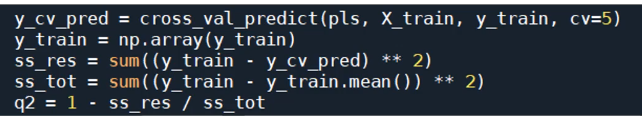

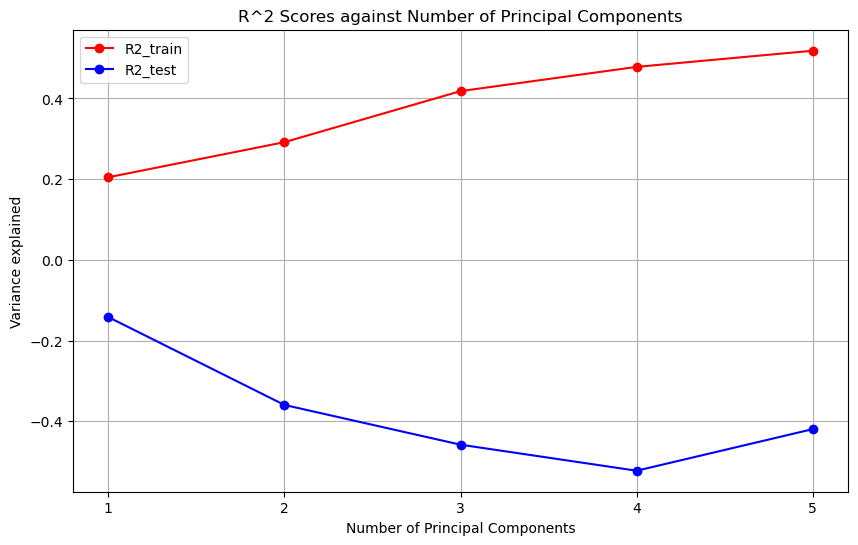

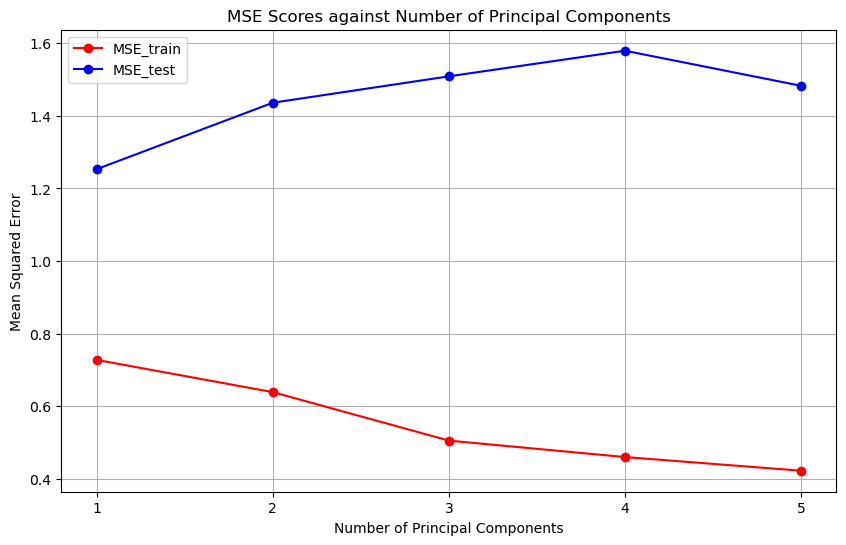

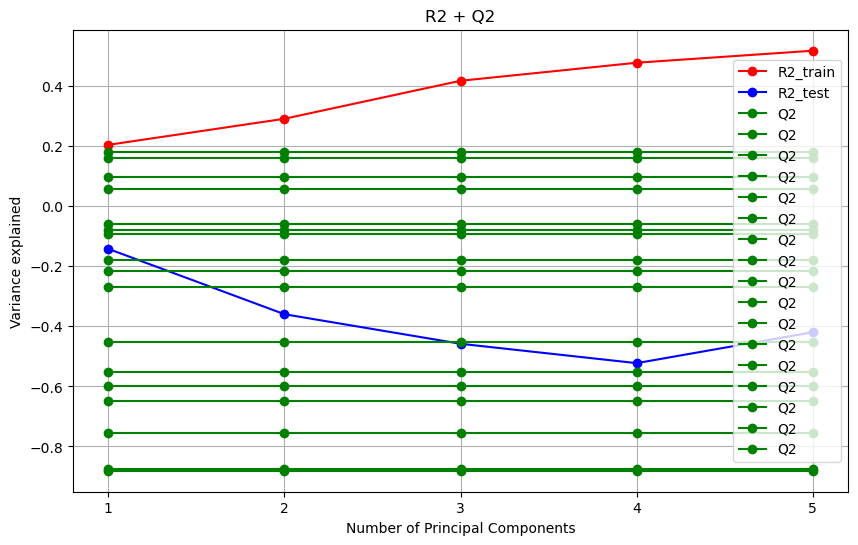

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cross_decomposition import PLSRegression

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Perform PLS with n components
n_comp = 5
pls = PLSRegression(n_components=n_comp)
pls.fit(X_train, y_train)

# Transform training and test sets
X_train_pls = pls.transform(X_train)
X_test_pls = pls.transform(X_test)

# Lists to store R2 scores and MSE scores
R2_train_scores = []
R2_test_scores = []
MSE_train_scores = []
MSE_test_scores = []
Q2_scores = []

# Train and calculate R2 for each principal component
for i in range(1, n_comp + 1):
    model = PLSRegression(n_components=i)
    model.fit(X_train_pls[:, :i], y_train)  # Train on the first i components
    
    # Predictions
    y_train_pred = model.predict(X_train_pls[:, :i])
    y_test_pred = model.predict(X_test_pls[:, :i])

    # Calculate R2 and MSE for train and test sets
    R2_train_scores.append(r2_score(y_train, y_train_pred))
    R2_test_scores.append(r2_score(y_test, y_test_pred))
    MSE_train_scores.append(mean_squared_error(y_train, y_train_pred))
    MSE_test_scores.append(mean_squared_error(y_test, y_test_pred))

    # Cross-validation for Q2 calculation
    y_cv_pred = cross_val_predict(pls, X_train, y_train, cv=5)
    y_train = np.array(y_train)
    ss_res = sum((y_train - y_cv_pred) ** 2)
    ss_total = sum((y_train - y_train.mean()) ** 2)
    q2 = 1 - ss_res / ss_total
    Q2_scores.append(q2)

# Plotting R2 train and test
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(R2_train_scores) + 1), R2_train_scores, marker='o', label='R2_train', color='red')
plt.plot(range(1, len(R2_test_scores) + 1), R2_test_scores, marker='o', label='R2_test', color='blue')
plt.title('R^2 Scores against Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance explained')
plt.xticks(range(1, len(R2_train_scores) + 1))
plt.grid()
plt.legend()
plt.show()

# Plotting MSE train and test
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(MSE_train_scores) + 1), MSE_train_scores, marker='o', label='MSE_train', color='red')
plt.plot(range(1, len(MSE_test_scores) + 1), MSE_test_scores, marker='o', label='MSE_test', color='blue')
plt.title('MSE Scores against Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Squared Error')
plt.xticks(range(1, len(MSE_train_scores) + 1))
plt.grid()
plt.legend()
plt.show()

# Plotting R2 and Q2
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(R2_train_scores) + 1), R2_train_scores, marker='o', label='R2_train', color='red')
plt.plot(range(1, len(R2_test_scores) + 1), R2_test_scores, marker='o', label='R2_test', color='blue')
plt.plot(range(1, len(Q2_scores) + 1), Q2_scores, marker='o', label='Q2', color='green')
plt.title('R2 + Q2')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance explained')
plt.xticks(range(1, len(R2_train_scores) + 1))
plt.grid()
plt.legend()
plt.show()



In [53]:
print(f'X_scaled: {X_scaled}')
print(f'y_scaled: {y_scaled}')

X_scaled: [[-7.05639506e-02 -5.30214844e-01 -9.20278220e-01 ... -1.75292979e+00
  -4.31177377e-01 -1.63160333e+00]
 [-6.94310015e-01 -1.52569410e+00 -2.37874225e+00 ... -7.65250583e-01
  -2.05420386e+00 -1.18635077e+00]
 [-2.67235132e-01 -7.92134356e-02 -4.50739951e-01 ...  8.20679344e-01
  -1.15931880e-01 -1.99612787e-01]
 ...
 [-1.85305318e+00 -1.66028991e+00 -1.12651316e+00 ... -4.27494348e-01
  -1.78554384e+00  2.91243794e-01]
 [-1.10542933e+00 -5.23124428e-01 -1.25728530e-01 ... -5.82367800e-01
  -4.46413641e-01  1.58477105e-01]
 [-7.46681469e-01  1.82319921e-03  8.28079077e-01 ...  7.49648495e-02
   1.06849923e+00  6.94661521e-01]]
y_scaled: [[ 1.31418760e+00  6.80130818e-01 -8.47773984e-01 -1.20608076e+00
  -6.79612138e-01 -2.74476222e-01  2.06065745e+00  7.91410215e-01
  -2.15772853e+00 -5.68990422e-01 -4.90708467e-02  8.30253284e-02
   6.89376968e-01  1.84971511e+00 -1.02819934e+00 -1.99981433e-01
  -1.33003787e-02]
 [-5.84781123e-01  8.31822891e-02 -1.21146963e-01  6.31498844

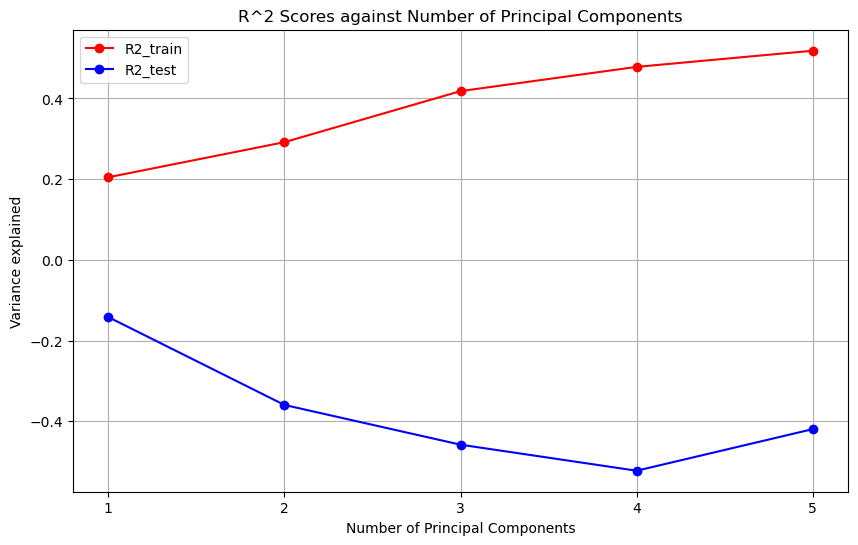

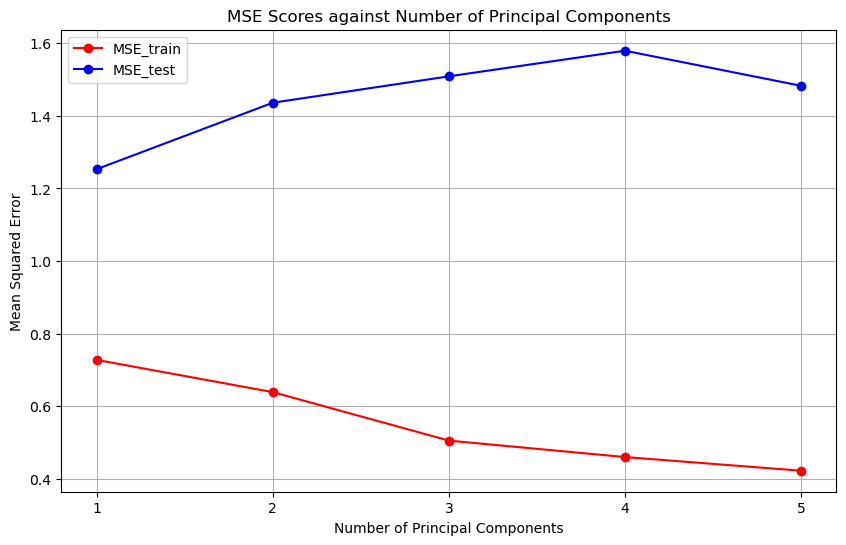

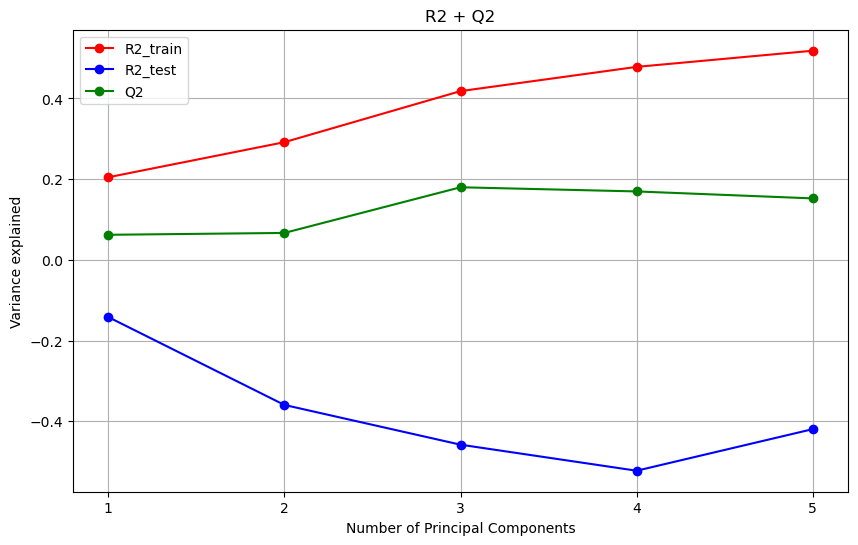

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cross_decomposition import PLSRegression

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Perform PLS with n components
n_comp = 5
pls = PLSRegression(n_components=n_comp)
pls.fit(X_train, y_train)

# Transform training and test sets
X_train_pls = pls.transform(X_train)
X_test_pls = pls.transform(X_test)


# Lists to store R2 scores and MSE scores
R2_train_scores = []
R2_test_scores = []
MSE_train_scores = []
MSE_test_scores = []
Q2_scores = []

# Train and calculate R2 for each principal component
for i in range(1, n_comp + 1):
    model = PLSRegression(n_components=i)
    model.fit(X_train_pls[:, :i], y_train)  # Train on the first i components
    
    y_train_pred = model.predict(X_train_pls[:, :i])
    y_test_pred = model.predict(X_test_pls[:, :i])
    
    # Calculate R^2 and MSE scores
    R2_train_scores.append(r2_score(y_train, y_train_pred))
    R2_test_scores.append(r2_score(y_test, y_test_pred))
    MSE_train_scores.append(mean_squared_error(y_train, y_train_pred))
    MSE_test_scores.append(mean_squared_error(y_test, y_test_pred))
    
    # Cross-validation for Q2
    y_cv_pred = cross_val_predict(model, X_train_pls[:, :i], y_train, cv=5)
    ss_res = np.sum((y_train - y_cv_pred) ** 2)  # Residual sum of squares
    ss_total = np.sum((y_train - np.mean(y_train)) ** 2)  # Total sum of squares
    q2 = 1 - (ss_res / ss_total)  # Q2 calculation
    Q2_scores.append(q2)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(R2_train_scores) + 1), R2_train_scores, marker='o', label='R2_train', color='red')
plt.plot(range(1, len(R2_test_scores) + 1), R2_test_scores, marker='o', label='R2_test', color='blue')
plt.title('R^2 Scores against Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance explained')
plt.xticks(range(1, len(R2_train_scores) + 1))
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(MSE_train_scores) + 1), MSE_train_scores, marker='o', label='MSE_train', color='red')
plt.plot(range(1, len(MSE_test_scores) + 1), MSE_test_scores, marker='o', label='MSE_test', color='blue')
plt.title('MSE Scores against Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Squared Error')
plt.xticks(range(1, len(MSE_train_scores) + 1))
plt.grid()
plt.legend()
plt.show()

# Plotting R2 and Q2
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(R2_train_scores) + 1), R2_train_scores, marker='o', label='R2_train', color='red')
plt.plot(range(1, len(R2_test_scores) + 1), R2_test_scores, marker='o', label='R2_test', color='blue')
plt.plot(range(1, len(Q2_scores) + 1), Q2_scores, marker='o', label='Q2', color='green')
plt.title('R2 + Q2')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance explained')
plt.xticks(range(1, len(R2_train_scores) + 1))
plt.grid()
plt.legend()
plt.show()


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Perform PLS
n_comp = 5
pca = PCA(n_components=n_comp)
X_train_pca = pls.transform(X_train)
X_test_pca = pls.transform(X_test)

# Lists to store R2 scores and MSE scores
R2_train_scores = []
R2_test_scores = []
MSE_train_scores = []
MSE_test_scores = []
Q2_scores = []

# Train and calculate R2 and Q2 for each principal component
for i in range(1, n_comp + 1):
    model = PCA(n_components=i)
    model.fit(X_train_pca[:, :i], y_train)  # Train on the first i components
    y_train_pred = model.predict(X_train_pca[:, :i])
    y_test_pred = model.predict(X_test_pca[:, :i])

    # Calculate R^2 and MSE scores
    R2_train_scores.append(r2_score(y_train, y_train_pred))
    R2_test_scores.append(r2_score(y_test, y_test_pred))
    # print(y_test)
    # print(y_test_pred)
    # print(r2_score(y_test, y_test_pred))

    MSE_train_scores.append(mean_squared_error(y_train, y_train_pred))
    MSE_test_scores.append(mean_squared_error(y_test, y_test_pred))

    # # Cross-validation prediction for Q2 calculation
    # y_cv_pred = cross_val_predict(model, X_train_pls[:, :i], y_train, cv=5)  # Use model for cross-validation
    # ss_res = np.sum((y_train - y_cv_pred) ** 2)  # Residual sum of squares
    # ss_total = np.sum((y_train - np.mean(y_train)) ** 2)  # Total sum of squares
    # q2 = 1 - (ss_res / ss_total)  # Q2 calculation
    # Q2_scores.append(q2)

# Plotting R2 scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(R2_train_scores) + 1), R2_train_scores, marker='o', label='R2_train', color='red')
plt.plot(range(1, len(R2_test_scores) + 1), R2_test_scores, marker='o', label='R2_test', color='blue')
plt.title('R^2 Scores against Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance explained')
plt.xticks(range(1, len(R2_train_scores) + 1))
plt.grid()
plt.legend()
plt.show()

# Plotting MSE scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(MSE_train_scores) + 1), MSE_train_scores, marker='o', label='MSE_train', color='red')
plt.plot(range(1, len(MSE_test_scores) + 1), MSE_test_scores, marker='o', label='MSE_test', color='blue')
plt.title('MSE Scores against Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Squared Error')
plt.xticks(range(1, len(MSE_train_scores) + 1))
plt.grid()
plt.legend()
plt.show()

# # Plotting R2 and Q2
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(R2_train_scores) + 1), R2_train_scores, marker='o', label='R2_train', color='red')
# plt.plot(range(1, len(R2_test_scores) + 1), R2_test_scores, marker='o', label='R2_test', color='blue')
# plt.plot(range(1, len(Q2_scores) + 1), Q2_scores, marker='o', label='Q2', color='green')  # Ensure correct range
# plt.title('R2 and Q2 Scores')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Variance explained')
# plt.xticks(range(1, len(R2_train_scores) + 1))
# plt.grid()
# plt.legend()
plt.show()


AttributeError: 'PCA' object has no attribute 'predict'

Suggested number of components:  1


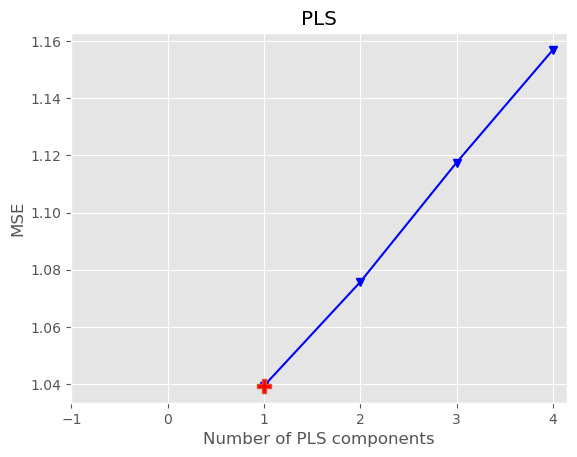

R2 calib: 0.205
R2 CV: -0.130
MSE calib: 0.728
MSE CV: 1.039


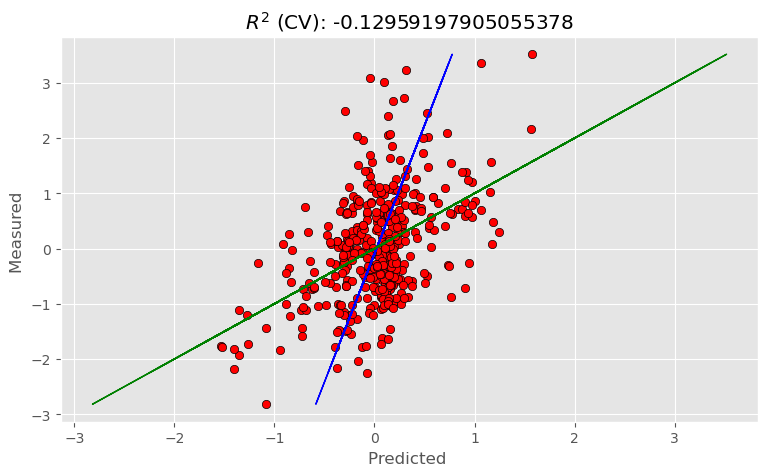

PLSRegression(n_components=1)

In [44]:
# Function to optimize PLS components via cross-validation
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    mse = []
    component = np.arange(1, n_comp)

    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=5)
        mse.append(mean_squared_error(y, y_cv))

    # Calculate position of minimum MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin + 1)

    # Plot the components vs MSE if requested
    if plot_components:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color='blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()

    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin + 1)
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)

    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=5)

    # Calculate R2 and MSE for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calib: %5.3f' % score_c)
    print('R2 CV: %5.3f' % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)

    # Plot regression results
    z = np.polyfit(y.flatten(), y_c.flatten(), 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        # Plot best fit line
        ax.plot(np.polyval(z, y), y, c='blue', linewidth=1)
        # Plot ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): ' + str(score_cv))
        plt.xlabel('Predicted ')
        plt.ylabel('Measured ')
        plt.show()

    return pls_opt

# Run the optimisation function
optimise_pls_cv(X_train, y_train, 5, plot_components=True)

In [45]:
y.CO2

0      615.330017
1      316.290008
2      282.640015
3      582.960022
4      230.509995
5      766.119934
6      391.709992
7      623.260010
8      242.990005
9      448.760010
10     595.669983
11    1363.599976
12     393.190033
13     655.599976
14     464.430023
15     343.559967
16    1028.500000
17     484.319977
18    1007.599915
19     161.500000
20     312.709992
21     248.220001
22     297.459992
24     269.549988
25     165.289993
27     519.739990
28     169.500000
29     398.440002
30     123.830002
31     292.279999
32     166.679993
33     503.850006
34     427.299988
35     136.570007
37     315.079987
38     312.079987
39     364.290008
Name: CO2, dtype: float64

In [46]:
# import sys

In [47]:
# def pls_variable_selection(X, y, max_comp):
    
#     X = np.array(X)
#     y = np.array(y)
#     # Define MSE array to be populated
#     mse = np.zeros((max_comp,X.shape[1]))
 
#     # Loop over the number of PLS components
#     for i in range(max_comp):
        
#         # Regression with specified number of components, using full spectrum
#         pls1 = PLSRegression(n_components=i+1)
#         pls1.fit(X, y)
        
#         # Indices of sort spectra according to ascending absolute value of PLS coefficients
#         sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
 
#         # Sort spectra accordingly 
#         Xc = X[:,sorted_ind]
 
#         # Discard one wavelength at a time of the sorted spectra,
#         # regress, and calculate the MSE cross-validation
#         for j in range(Xc.shape[1]-(i+1)):
 
#             pls2 = PLSRegression(n_components=i+1)
#             pls2.fit(Xc[:, j:], y)
            
#             y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
 
#             mse[i,j] = mean_squared_error(y, y_cv)
    
#         comp = 100*(i+1)/(max_comp)
#         sys.stdout.write("\r%d%% completed" % comp)
#         sys.stdout.flush()
#     sys.stdout.write("\n")
 
#     # # Calculate and print the position of minimum in MSE
#     mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
 
#     print("Optimised number of PLS components: ", mseminx[0]+1)
#     print("Wavelengths to be discarded ",mseminy[0])
#     print('Optimised MSEP ', mse[mseminx,mseminy][0])
#     sys.stdout.write("\n")
#     # plt.imshow(mse, interpolation=None)
#     # plt.show()
 
 
#     # Calculate PLS with optimal components and export values
#     pls = PLSRegression(n_components=mseminx[0]+1)
#     pls.fit(X, y)
        
#     sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
 
#     Xc = X[:,sorted_ind]
 
#     return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [48]:
# def simple_pls_cv(X, y, n_comp):
 
#     # Run PLS with suggested number of components
#     pls = PLSRegression(n_components=n_comp)
#     pls.fit(X, y)
#     y_c = pls.predict(X)
 
#     # Cross-validation
#     y_cv = cross_val_predict(pls, X, y, cv=10)    
 
#     # Calculate scores for calibration and cross-validation
#     score_c = r2_score(y, y_c)
#     score_cv = r2_score(y, y_cv)
 
#     # Calculate mean square error for calibration and cross validation
#     mse_c = mean_squared_error(y, y_c)
#     mse_cv = mean_squared_error(y, y_cv)
 
#     print('R2 calib: %5.3f'  % score_c)
#     print('R2 CV: %5.3f'  % score_cv)
#     print('MSE calib: %5.3f' % mse_c)
#     print('MSE CV: %5.3f' % mse_cv)
 
#     # Plot regression 
 
#     z = np.polyfit(y, y_cv, 1)
#     with plt.style.context(('ggplot')):
#         fig, ax = plt.subplots(figsize=(9, 5))
#         ax.scatter(y_cv, y, c='red', edgecolors='k')
#         ax.plot(z[1]+z[0]*y, y, c='blue', linewidth=1)
#         ax.plot(y, y, color='green', linewidth=1)
#         plt.title('$R^{2}$ (CV): '+str(score_cv))
#         plt.xlabel('Predicted $^{\circ}$Brix')
#         plt.ylabel('Measured $^{\circ}$Brix')
        
#         plt.show()

In [49]:
# opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X, y, 40)
# simple_pls_cv(opt_Xc, y, ncomp)

NameError: name 'pls_variable_selection' is not defined

Split 


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [54]:
# Standardize the datasets
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

ValueError: could not convert string to float: 'white'

In [55]:
X#  Split the data into training and testing sets
X_train, x_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [57]:
pls = PLSRegression(n_components=15)  # suggest component numbers from cross-validation
pls.fit(X_train, y_train)

PLSRegression(n_components=15)

In [58]:
y_pred = pls.predict(x_test)

In [60]:

#  Inverse transform the predicted and actual values back to original scale
y_pred_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test)

In [61]:
# 8. Evaluate the model
print("R^2 score:", r2_score(y_test_orig, y_pred_orig))
print("Mean Squared Error:", mean_squared_error(y_test_orig, y_pred_orig))

R^2 score: -0.1997549234460229
Mean Squared Error: 5523.199251421486


## Assignment 1 continued: Classification
PLS plots and regression modeling focus on the variables measured and only indirectly involve the treatments of the study (in this case wine type). Here we focus on the ability of the data to classify the different treatments (wine color). Keep in mind that classification involves categorizing the levels of a treatment based on the response variables, not studying the response variables themselves.
- Use KNeighborsClassifier to classify wine type by first the chemical measures, and then
the NMR variables. Do the chemical measures or NMR classify wine type better? Show
the confusion charts. Discuss the results in terms of accuracy and precision. Why might
classification of wine samples be important?
- Extra analyses include using another model (ie LogisticRegression), limiting the variables
to those found influential in Effects Plots, creating decision boundary plots and
reorganizing the levels to improve classification.

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder

In [81]:
le = LabelEncoder()
y['color'] = le.fit_transform(y['color'])  # # Encode 'white' and 'red' to numbers

0    2
1    0
2    0
3    2
4    0
Name: color, dtype: int32

In [84]:
# Chemical measures
X_chemical = y[['Malic', 'Ethanol', 'Total', 'Volatile', 'Lactic_Acid', 'Tartaric', 'Glucose', 'Density', 'Folin', 'Glycerol', 'Gluconic', 'Sorbic', 'CO2', 'Citric', 'Methanol', 'Ethylacetate', 'pH']]
y = y['color']

# NMR features (assuming they are in columns after chemical measures)
X_nmr = X.drop(columns=['Sample', 'color'])  # Drop 'Sample' and target variable


KeyError: "None of [Index(['Malic', 'Ethanol', 'Total', 'Volatile', 'Lactic_Acid', 'Tartaric',\n       'Glucose', 'Density', 'Folin', 'Glycerol', 'Gluconic', 'Sorbic', 'CO2',\n       'Citric', 'Methanol', 'Ethylacetate', 'pH'],\n      dtype='object')] are in the [index]"

,Sample,color,Malic,Ethanol,Total,Volatile,Lactic_Acid,Tartaric,Glucose,Density,Folin,Glycerol,Gluconic,Sorbic,CO2,Citric,Methanol,Ethylacetate,pH
0,1,white,1.65910,13.362,3.2351,0.20197,0.22088,1.9346,6.802000,0.99610,3.454600,7.188799,0.12511,-1.228100,615.330017,0.663300,0.059090,39.568001,3.41
1,2,red,0.21406,12.887,3.4987,0.46754,0.88723,2.5563,0.063616,0.99409,59.650005,8.257400,0.51029,17.209999,316.290008,0.089694,0.184830,252.929993,3.42
2,3,red,0.24519,13.044,3.6213,0.48614,1.35750,2.4463,1.097400,0.99705,68.738998,9.604400,1.41650,16.408001,282.640015,0.266330,0.180190,-58.270000,3.64
3,4,white,2.25610,11.848,3.7846,0.22775,0.30157,1.5710,0.403360,0.99291,10.412000,7.121000,0.34523,37.365002,582.960022,0.323460,0.053365,470.079987,3.24
4,5,red,0.29423,13.613,2.9792,0.53859,1.48750,1.9834,1.770200,0.99666,75.089996,8.950600,-1.71850,-115.079994,230.509995,0.058963,0.112100,-222.850021,3.64


In [79]:
y_class = pd.get_dummies(y, columns=['color'])
y_class.columns

Index(['Sample', 'Malic', 'Ethanol', 'Total', 'Volatile', 'Lactic_Acid',
       'Tartaric', 'Glucose', 'Density', 'Folin', 'Glycerol', 'Gluconic',
       'Sorbic', 'CO2', 'Citric', 'Methanol', 'Ethylacetate', 'pH',
       'color_red', 'color_rose', 'color_white'],
      dtype='object')

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_class, test_size=0.3)
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

ValueError: y should be a 1d array, got an array of shape (25, 21) instead.

In [70]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train ,y_train)
ypred = knn.predict(xtest)
from sklearn.metrics import accuracy_score
accuracy_score(ypred,ytest)

ValueError: Unknown label type: continuous-multioutput. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.